<a href="https://colab.research.google.com/github/mgp87/Jupyter_Notebooks_Collection/blob/main/Multimodal_RAG_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Installing dependencies

In [ ]:
!pip install clip torch pillow datasets lancedb tqdm matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 14.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=380d649179992e2277f64e99918d8ac58139ad7f5664c260876ebfb087be9df8
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7_fo_1i3
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7_fo_1i3
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=ea223c40f67d7f76d57a39db090ffc2ef7872f6cc1bfd8221749510ca90b365a
  Stored in directory: /tmp/pip-ephem-wheel-cache-tkolu_tx/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: clip
    Found existing installation: clip 0.2.0
    Uninstalling clip-0.2.0:
      Successfully uninstalled clip-0.2.0


In [ ]:
import clip
import torch
import os
from datasets import load_dataset

ds = load_dataset("vipulmaheshwari/GTA-Image-Captioning-Dataset")
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

Generating train split:   0%|          | 0/785 [00:00<?, ? examples/s]

100%|████████████████████████████████████████| 890M/890M [00:09<00:00, 101MiB/s]


In [ ]:
def embed_image(img):
    processed_image = preprocess(img)
    unsqueezed_image = processed_image.unsqueeze(0).to(device)
    embeddings = model.encode_image(unsqueezed_image)

    # Detach, move to CPU, convert to numpy array, and extract the first element as a list
    result = embeddings.detach().cpu().numpy()[0].tolist()
    return result

In [ ]:
import pyarrow as pa
import lancedb
import tqdm

# define a schema for the lancedb table
db = lancedb.connect('./data/tables')
schema = pa.schema(
  [
      pa.field("vector", pa.list_(pa.float32(), 768)),
      pa.field("text", pa.string()),
      pa.field("id", pa.int32())
  ])
tbl = db.create_table("gta_data", schema=schema, mode="overwrite")#append the data into the table

In [ ]:
data = []
for i in range(len(ds["train"])):
    img = ds["train"][i]['image']
    text = ds["train"][i]['text']

    # Encode the image
    encoded_img = embed_image(img)
    data.append({"vector": encoded_img, "text": text, "id" : i})

In [ ]:
tbl.add(data)
tbl.to_pandas()

,vector,text,id
0,"[0.97021484, 0.36328125, -0.044433594, -0.0945...",there is a man walking down a hill with a skat...,0
1,"[1.1689453, 0.57714844, -0.110961914, -0.50976...",there is a street with a yellow line on it and...,1
2,"[0.88623047, 0.39379883, -0.16687012, -0.47290...",there is a street with a sign on the side of it,2
3,"[1.0488281, 0.39526367, -0.19543457, -0.682128...",there is a picture of a street with a red car ...,3
4,"[0.91503906, 0.5126953, -0.06665039, -0.700195...",there is a street with a yellow sign on the si...,4
...,...,...,...
780,"[1.2265625, 0.16955566, 0.6230469, -0.92626953...",there is a motorcycle that is driving down the...,780
781,"[1.2275391, 0.25854492, 0.6479492, -0.93408203...",there is a truck that is driving down the road,781
782,"[1.2705078, 0.2052002, 0.6635742, -1.1396484, ...",there is a road with a yellow line going down it,782
783,"[1.3203125, 0.071899414, 0.50390625, -1.117187...",there is a truck driving down the road in the ...,783


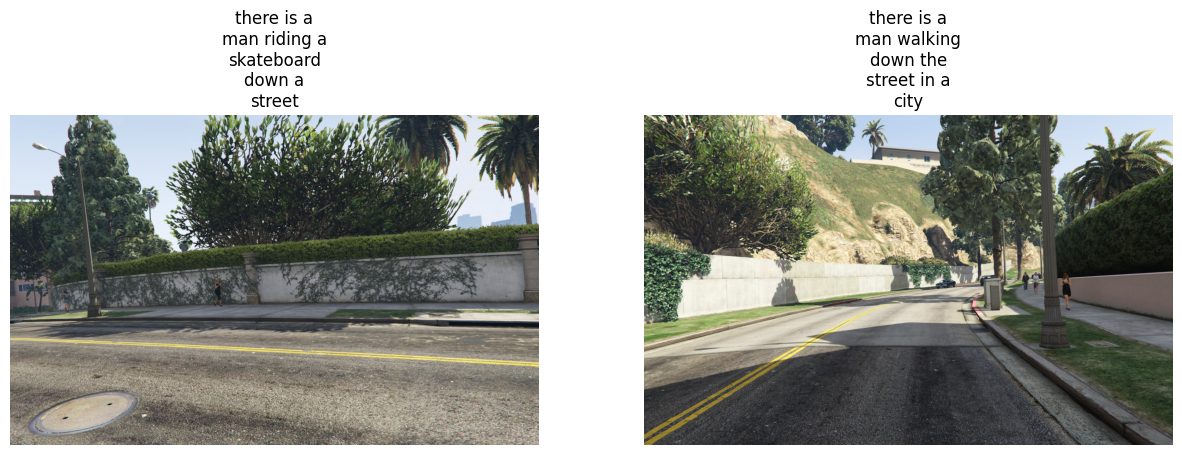

In [ ]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, captions):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

# Assuming ds is a dictionary with "train" key containing a list of samples
sample_dataset = ds["train"]
random_indices = np.random.choice(len(sample_dataset), size=2, replace=False)
random_indices = [index.item() for index in random_indices]

# Get the random images and their captions
random_images = [np.array(sample_dataset[index]["image"]) for index in random_indices]
random_captions = [sample_dataset[index]["text"] for index in random_indices]

# Plot the random images with their captions
plot_images(random_images, random_captions)

# Show the plot
plt.show()


In [ ]:
def embed_txt(txt):
    tokenized_text = clip.tokenize([txt]).to(device)
    embeddings = model.encode_text(tokenized_text)

    # Detach, move to CPU, convert to numpy array, and extract the first element as a list
    result = embeddings.detach().cpu().numpy()[0].tolist()
    return result

In [ ]:
res = tbl.search(embed_txt("a stop sign")).limit(5).to_pandas()
res

,vector,text,id,_distance
0,"[0.67822266, 0.057281494, 0.0031871796, -0.384...",there is a truck driving down a street with a ...,569,440.371674
1,"[0.84228516, 0.33911133, 0.18481445, -0.500488...",there is a bus that is driving down the street,423,441.476532
2,"[0.8066406, 0.31445312, 0.06011963, -0.5502929...",there is a stop sign on the corner of a street,548,441.536255
3,"[0.92871094, 0.2878418, -0.3720703, -0.2252197...",there is a stop sign on the corner of a street,169,443.978790
4,"[0.66503906, 0.35498047, 0.08538818, -0.628417...",there is a stop sign painted on the side of a ...,477,447.241608


In [ ]:
# Display the relevant image based on the retrieved ID
data_id = int(res['id'][0])
display(ds["train"][data_id]['image'])
print(ds["train"][data_id]['text'])